# Libraries & setup

In [ ]:
! pip install tqdm boto3 requests regex sentencepiece sacremoses
# Packages must be loaded in this order or "torch.hub.load" does not work.
# Probably there is a version conflict!?
! pip install accelerate -U
! pip install transformers[torch] huggingface_hub datasets
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
# from datasets import load_metric ## load_metric is deprecated
from evaluate import load

import torch

from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

# import wandb

# Download data

In [ ]:
! pip install -q kaggle

In [ ]:
# Upload the "kaggle.json" file
files.upload()

In [ ]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# remove the file from wd
! rm kaggle.json

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Check of the file is in the folder
!ls -a ~/.kaggle/
# ! ls ../content

.  ..  kaggle.json


In [ ]:
# Download Data: !kaggle competitions download -c 'name-of-competition'
! kaggle competitions download -c "nlp-getting-started"

100% 593k/593k [00:00<00:00, 1.03MB/s]
100% 593k/593k [00:00<00:00, 1.03MB/s]


In [ ]:
# Create a directory named train,
! mkdir data

# unzip train data there,
! unzip nlp-getting-started.zip -d data
! rm nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Import data

In [ ]:
df_train_val = pd.read_csv("./data/train.csv")
df_train_val.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train_val.iloc[100:105, :]

,id,keyword,location,text,target
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0
103,149,aftershock,304,'The man who can drive himself further once th...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0


In [ ]:
for i, text in enumerate(df_train_val["text"][:5]):
  print(f"{i} - {text}")

0 - Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 - Forest fire near La Ronge Sask. Canada
2 - All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 - 13,000 people receive #wildfires evacuation orders in California 
4 - Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


# Create train & validation datasets

In [ ]:
train_val_texts = df_train_val["text"]
train_val_labels = df_train_val["target"]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True)

train_dataset = Dataset.from_dict({
    "text": train_texts,
    "label": train_labels
})

val_dataset = Dataset.from_dict({
    "text": val_texts,
    "label": val_labels
})

raw_datasets = DatasetDict({
    "train": train_dataset,
    "val": val_dataset
})

raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6090
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1523
    })
})

In [ ]:
for i in range(50, 55):
  print(f'Label: {raw_datasets["train"][i]["label"]}')
  print(f'Text:\n{raw_datasets["train"][i]["text"]}')
  print("="*80)

Label: 0
Text:
Set a new record.... 7 states in 4 days. I don't even know where I am when I wake up anymore. What a whirlwind! Loving every minute though.
Label: 1
Text:
./.....hmm 12000 Nigerian refugees repatriated from Cameroon http://t.co/YTW9SlWvmg /(
Label: 1
Text:
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'
Label: 1
Text:
Lone Survivor: The Eyewitness Account of Operation Redwing and the Lost Heroes of SEAL TeamÛ_ http://t.co/NXtWXJCAVh http://t.co/oL8ESFRGLE
Label: 1
Text:
@MartinMJ22 @YouGov When did a 12 seat majority with 36% of the vote become a landslide?


# Tokenizer

In [ ]:
pretrained_model_id = "bert-base-uncased"

# Using torch
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', pretrained_model_id)

# Using "transformers"
tokenizer_trfm = AutoTokenizer.from_pretrained(pretrained_model_id)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


In [ ]:
tokenizer("Don't read this sentence")

{'input_ids': [101, 2123, 1005, 1056, 3191, 2023, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer_trfm("Don't read this sentence")

{'input_ids': [101, 2123, 1005, 1056, 3191, 2023, 6251, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.encode("Don't read this sentence", add_special_tokens=True)

[101, 2123, 1005, 1056, 3191, 2023, 6251, 102]

In [ ]:
tokenizer("Don't read this sentence", truncation=True, padding='max_length', max_length=10)

{'input_ids': [101, 2123, 1005, 1056, 3191, 2023, 6251, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

In [ ]:
def tokenize_function(example):
  return tokenizer(example["text"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

In [ ]:
for i in range(50, 52):
  print(f'Label: {tokenized_datasets["train"][i]["label"]}')
  print(f'Text:\n{tokenized_datasets["train"][i]["text"]}')
  print(f'Input ID:\n{tokenized_datasets["train"][i]["input_ids"]}')
  print(f'Lenght: {len(tokenized_datasets["train"][i]["input_ids"])}')
  print("="*80)

Label: 0
Text:
Set a new record.... 7 states in 4 days. I don't even know where I am when I wake up anymore. What a whirlwind! Loving every minute though.
Input ID:
[101, 2275, 1037, 2047, 2501, 1012, 1012, 1012, 1012, 1021, 2163, 1999, 1018, 2420, 1012, 1045, 2123, 1005, 1056, 2130, 2113, 2073, 1045, 2572, 2043, 1045, 5256, 2039, 4902, 1012, 2054, 1037, 1059, 11961, 2140, 11101, 999, 8295, 2296, 3371, 2295, 1012, 102]
Lenght: 43
Label: 1
Text:
./.....hmm 12000 Nigerian refugees repatriated from Cameroon http://t.co/YTW9SlWvmg /(
Input ID:
[101, 1012, 1013, 1012, 1012, 1012, 1012, 1012, 17012, 14840, 2692, 11884, 8711, 16360, 4017, 25475, 2013, 13841, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1061, 2102, 2860, 2683, 14540, 2860, 2615, 24798, 1013, 1006, 102]
Lenght: 37


# Model

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
BATH_SIZE = 128 # 64
EPOCHS = 6

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # accuracy_metric = load_metric("accuracy") # load_metric is deprecated
    accuracy_metric = load("accuracy")
    # f1_metric = load_metric("f1") # load_metric is deprecated
    f1_metric = load("f1")

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")  # for macro F1

    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results', # output directory
    evaluation_strategy="epoch", # evaluation is done at the end of each epoch
    num_train_epochs=EPOCHS, # number of training epochs
    per_device_train_batch_size=BATH_SIZE, # batch size per device during training
    per_device_eval_batch_size=BATH_SIZE, # batch size for evaluation
    fp16=True, # Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training
    logging_strategy="epoch", # Logging is done at the end of each epoch
)

In [ ]:
model = torch.hub.load(
    'huggingface/pytorch-transformers',
    'modelForSequenceClassification',
    pretrained_model_id,
    num_labels=2)

model.cuda()
# print(model)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
trainer = Trainer(
    model=model, # the instantiated Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=tokenized_datasets["train"], # training dataset
    eval_dataset=tokenized_datasets["val"], # evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.467400,0.392456,0.830598,0.825552
2,0.328900,0.495328,0.801707,0.799686
3,0.237000,0.465019,0.833224,0.828414
4,0.169200,0.571397,0.813526,0.810672
5,0.124300,0.601873,0.827315,0.823836
6,0.094900,0.659551,0.820749,0.817854


TrainOutput(global_step=288, training_loss=0.23694225317902035, metrics={'train_runtime': 66.8367, 'train_samples_per_second': 546.706, 'train_steps_per_second': 4.309, 'total_flos': 1211599687716240.0, 'train_loss': 0.23694225317902035, 'epoch': 6.0})

In [ ]:
train_val_logs = trainer.state

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6595506072044373,
 'eval_accuracy': 0.8207485226526592,
 'eval_f1': 0.8178536929422408,
 'eval_runtime': 3.8855,
 'eval_samples_per_second': 391.973,
 'eval_steps_per_second': 3.088,
 'epoch': 6.0}

In [ ]:
# train_val_logs.log_history

In [ ]:
train_val_logs.log_history[0]

{'loss': 0.4674,
 'learning_rate': 4.166666666666667e-05,
 'epoch': 1.0,
 'step': 48}

In [ ]:
train_val_logs.log_history[1]

{'eval_loss': 0.39245638251304626,
 'eval_accuracy': 0.8305975049244911,
 'eval_f1': 0.8255524655841111,
 'eval_runtime': 4.9191,
 'eval_samples_per_second': 309.611,
 'eval_steps_per_second': 2.439,
 'epoch': 1.0,
 'step': 48}

In [ ]:
def get_loss_metrics(logs):
  epochs = int(logs.epoch) * 2 # "*2" need for "range()"
  train_loss = []
  val_loss = []
  val_accuracy = []
  val_f1 = []
  for i in range(0, epochs, 2):
    train_loss.append(logs.log_history[i]["loss"])
    val_loss.append(logs.log_history[i+1]["eval_loss"])
    val_accuracy.append(logs.log_history[i+1]["eval_accuracy"])
    val_f1.append(logs.log_history[i+1]["eval_f1"])
  return {"train_loss":train_loss, "val_loss":val_loss, "val_accuracy":val_accuracy, "val_f1":val_f1}

In [ ]:
val_logs = get_loss_metrics(train_val_logs)

In [ ]:
def render_history(logs):
  n_epochs = len(val_logs["train_loss"])
  x_epochs = np.arange(1, n_epochs+1)

  plt.figure(figsize=(10, 8))

  plt.subplot(2, 2, 1)
  plt.plot(x_epochs, logs["train_loss"], label="Training loss")
  plt.plot(x_epochs, logs["val_loss"], label="Validation loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend(frameon=False)

  plt.subplot(2, 2, 2)
  plt.plot(x_epochs, logs["val_accuracy"], label="Validation Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(x_epochs, logs["val_f1"], label="Validation F1")
  plt.ylabel("F1")
  plt.xlabel("Epochs")

  plt.legend()
  plt.show()

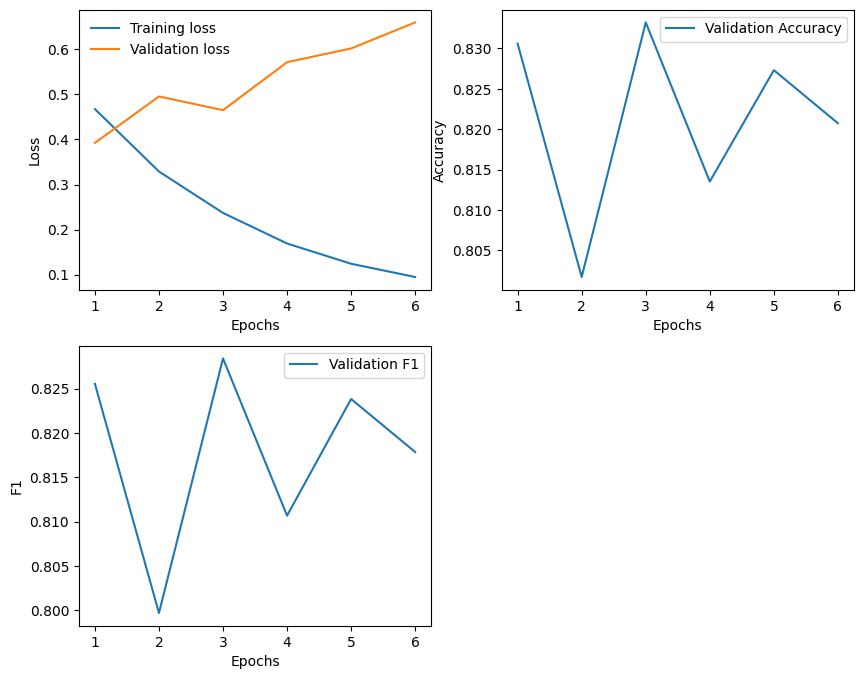

In [ ]:
render_history(val_logs)

# Refit model

In [ ]:
model_1epoch = torch.hub.load(
    'huggingface/pytorch-transformers',
    'modelForSequenceClassification',
    pretrained_model_id,
    num_labels=2)

model_1epoch.cuda()
# print(model_1epoch)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
BATH_SIZE = 128
EPOCHS = 1

training_args = TrainingArguments(
    output_dir='./results', # output directory
    evaluation_strategy="epoch", # evaluation is done at the end of each epoch
    num_train_epochs=EPOCHS, # number of training epochs
    per_device_train_batch_size=BATH_SIZE, # batch size per device during training
    per_device_eval_batch_size=BATH_SIZE, # batch size for evaluation
    fp16=True, # Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training
    logging_strategy="epoch", # Logging is done at the end of each epoch
)

trainer_1epoch = Trainer(
    model=model_1epoch, # the instantiated Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=tokenized_datasets["train"], # training dataset
    eval_dataset=tokenized_datasets["val"], # evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_1epoch.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.464900,0.401294,0.835194,0.830168


TrainOutput(global_step=48, training_loss=0.46488900979359943, metrics={'train_runtime': 11.1229, 'train_samples_per_second': 547.521, 'train_steps_per_second': 4.315, 'total_flos': 203284123592400.0, 'train_loss': 0.46488900979359943, 'epoch': 1.0})

In [ ]:
trainer_1epoch.evaluate()

{'eval_loss': 0.4012936055660248,
 'eval_accuracy': 0.835193696651346,
 'eval_f1': 0.8301676895976471,
 'eval_runtime': 4.2389,
 'eval_samples_per_second': 359.287,
 'eval_steps_per_second': 2.831,
 'epoch': 1.0}

# Test set

In [ ]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
def classify_text(text):
  # pt = pytorch
  inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to("cuda")
  outputs = model_1epoch(**inputs)
  probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
  predicted_class = torch.argmax(probabilities).item()
  return predicted_class

In [ ]:
classify_text(df_test["text"][4])

1

In [ ]:
df_test["text"][4]

'Typhoon Soudelor kills 28 in China and Taiwan'

In [ ]:
y_pred_test = df_test["text"].map(classify_text)

In [ ]:
y_pred_test.mean()

0.38308305240576157

In [ ]:
df_submission = pd.DataFrame({
    "id": df_test.id,
    "target": y_pred_test.astype(int)
})

df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
df_submission.to_csv("./data/test_submission.csv", index=False)